In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import APIFetcher as API
import json

plt.rcParams.update({
    'axes.facecolor': '#2E2E2E',
    'axes.titlecolor': 'white',
    'figure.facecolor': '#1E1E1E',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'grid.color': '#444444',
    'axes.edgecolor': 'white'
})

In [53]:
from numpy import shape


item_r = pd.read_csv('../data/data.csv', names=['item_id', 'avgHighPrice', 'highPriceVolume', 'avgLowPrice', 'lowPriceVolume', 'timestamp'])
with open("../data/data_properties.txt", "r") as file:
            lines = file.readlines()
series_lenght = int(lines[1].replace("\n", ""))
G_item_r = item_r.groupby('item_id').nunique()

with open("../data/namealchemy.json", "r") as file:
    data = json.load(file)

# Convert dictionary to DataFrame
high_alchemy = pd.DataFrame(list(data.items()), columns=["Item", "Price"])

with open("../data/nameID.json", "r") as file:
    data = json.load(file)

# Convert dictionary to DataFrame
nameID = pd.DataFrame(list(data.items()), columns=["Item", "ID"])

reference = pd.merge(nameID, high_alchemy, on="Item", how="inner")
reference= reference.drop([0,1])

reference.set_index('ID', inplace=True)  # Use the 'ID' column as the row index
reference.loc[561,'Item'] #Nature Rune

'Nature rune'

In [58]:
#n-1 to ensure proper time series ranging
filtered_indexes = G_item_r[G_item_r['timestamp'] != series_lenght].index
item_r = item_r[~item_r['item_id'].isin(filtered_indexes)]
# interpolate missing values
item_r = item_r.interpolate()
#Weighted average of High/Low Price by High/Low Volume
item_r['totalvol'] = item_r['highPriceVolume'] + item_r['lowPriceVolume']
item_r['wprice'] = (item_r['highPriceVolume']/item_r['totalvol']) * (item_r['avgHighPrice'] - item_r['avgLowPrice']) + item_r['avgLowPrice']
#transforming panel data to price and volume matrices
price_matrix_items = item_r.pivot(index="timestamp", columns="item_id", values="wprice")
vol_matrix_items = item_r.pivot(index='timestamp', columns='item_id', values='totalvol')
corr_price_items = price_matrix_items.corr()
corr_vol_items = vol_matrix_items.corr()

In [59]:
#volatility
volativity_sensitivity = 30
volatilityitems = price_matrix_items.rolling(window=volativity_sensitivity).std()
volatilitymarket = volatilityitems.sum(axis=1)
#Dividing by shape as count of row/column length
volatilitymarket = volatilitymarket/corr_price_items.shape[1]

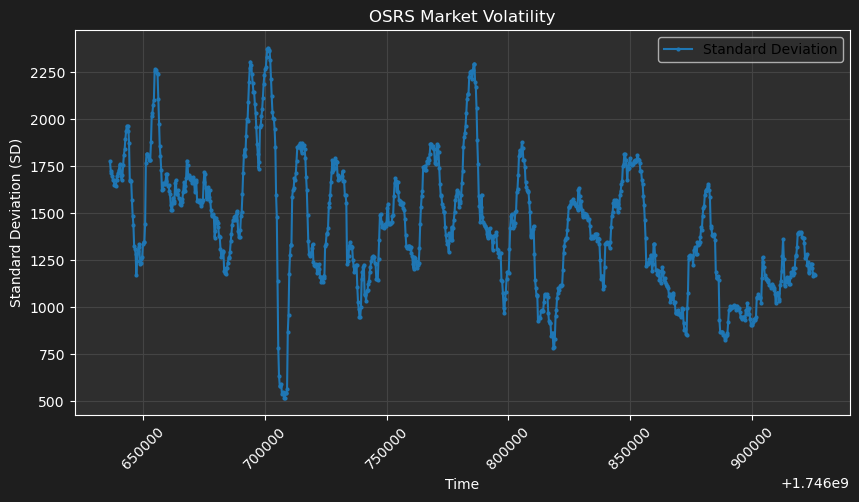

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(volatilitymarket.iloc[volativity_sensitivity:], marker="o", markersize='2', linestyle="-", label="Standard Deviation")

plt.xlabel("Time")
plt.ylabel("Standard Deviation (SD)")
plt.title("OSRS Market Volatility")
plt.legend()
plt.xticks(rotation=45)  # Rotate timestamps for clarity
plt.grid()

# Show the plot
plt.show()

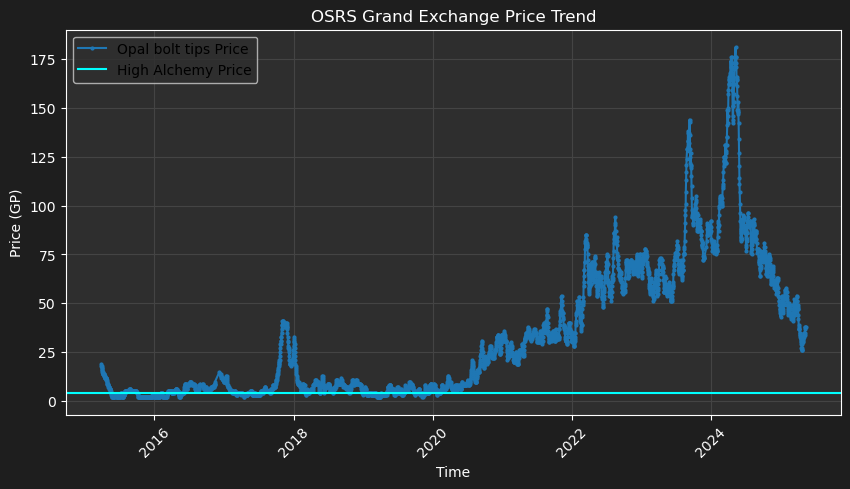

In [77]:
graphID = 45
if graphID in reference.index:
    nature = API.fetch_historical(graphID)
    plt.figure(figsize=(10, 5))
    plt.plot(nature['timestamp'], nature['price'], marker="o", markersize='2', linestyle="-", label=f"{reference.loc[graphID,'Item']} Price")
    plt.axhline(y=reference.loc[graphID,'Price'], color='cyan', linestyle='-', label='High Alchemy Price')

    plt.xlabel("Time")
    plt.ylabel("Price (GP)")
    plt.title("OSRS Grand Exchange Price Trend")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate timestamps for clarity
    plt.grid()

    # Show the plot
    plt.show()
else: print('Invalid ID')
